## CNN Evaluation

## 1. Preprocessing
### 1.1. Imports and load ground truth

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense



In [52]:
# Load ground truth
Ytrain = np.load('TrainGT_preprocessed.npy')
Ytest = np.load('TestGT_preprocessed.npy')

# Load data
Xtrain = np.load('Trainpics_preprocessed.npy')
Xtest = np.load('Testpics_preprocessed.npy')

In [53]:
selected_indices = np.where((Ytrain == 1) | (Ytrain == 2))[0]

# Reduziere Xtrain und Ytrain auf die ausgewählten Indizes
Xtrain = Xtrain[selected_indices, :]
Ytrain = Ytrain[selected_indices]


In [54]:
selected_indices = np.where((Ytest == 1) | (Ytest == 2))[0]

# Reduziere Xtest und Ytest auf die ausgewählten Indizes
Xtest = Xtest[selected_indices, :]
Ytest = Ytest[selected_indices]



In [55]:
Ytrain=Ytrain-1
Ytest=Ytest-1



In [56]:
num_classes = 2
from tensorflow.keras.utils import to_categorical
print(Ytrain.shape)
Ytrain = to_categorical(Ytrain, num_classes=num_classes)
Ytest =  to_categorical(Ytest, num_classes=num_classes)
print(Ytrain.shape)

(230,)
(230, 2)


In [58]:
from sklearn.model_selection import KFold
x = 60
y = 45
Xtrain=Xtrain.reshape(230,y,x,3)
Xtest=Xtest.reshape(70,y,x,3)

kf = KFold(n_splits=5, shuffle=True, random_state=1)
for fold, (train_index, val_index) in enumerate(kf.split(Xtrain, Ytrain)):
    X_train_fold, X_val_fold = Xtrain[train_index], Xtrain[val_index]
    Y_train_fold, Y_val_fold = Ytrain[train_index], Ytrain[val_index]

In [59]:
# Define your CNN model
def create_cnn_model(filters=16, kernel_size=(3, 3), pool_size=(2, 2), dense_units=64, learning_rate=0.001,activation='relu'):
    model = Sequential()
    model.add(Conv2D(filters, kernel_size, activation='relu', input_shape=(input_shape)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:


# Create CNN model
input_shape = (y, x, 3)  # Adjust these based on your data
num_classes = Ytrain.shape[1]  # Adjust based on your problem

cnn_model = create_cnn_model()

# Fit the model (assuming Xtrain and Ytrain are your training data)
cnn_model.fit(X_train_fold, Y_train_fold,epochs=10,validation_data=(X_val_fold, Y_val_fold))

# Continue with the rest of your code...





Epoch 1/10


21/21 [==============================] - 2s 41ms/step - loss: 2.1551 - accuracy: 0.1398 - val_loss: 1.9458 - val_accuracy: 0.1677
Epoch 2/10
21/21 [==============================] - 1s 26ms/step - loss: 1.9501 - accuracy: 0.1304 - val_loss: 1.9459 - val_accuracy: 0.1677
Epoch 3/10
21/21 [==============================] - 0s 24ms/step - loss: 1.9460 - accuracy: 0.1366 - val_loss: 1.9459 - val_accuracy: 0.1677
Epoch 4/10
21/21 [==============================] - 0s 23ms/step - loss: 1.9459 - accuracy: 0.1366 - val_loss: 1.9461 - val_accuracy: 0.1677
Epoch 5/10
21/21 [==============================] - 0s 24ms/step - loss: 1.9459 - accuracy: 0.1475 - val_loss: 1.9464 - val_accuracy: 0.1180
Epoch 6/10
21/21 [==============================] - 0s 23ms/step - loss: 1.9459 - accuracy: 0.1491 - val_loss: 1.9466 - val_accuracy: 0.1180
Epoch 7/10
21/21 [==============================] - 0s 23ms/step - loss: 1.9460 - accuracy: 0.1491 - val_loss: 1.9467 - val_accuracy: 0.1180
Epoch 8/

In [60]:
from tensorflow import keras
import keras_tuner

In [61]:


def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    activation = hp.Choice("activation", ["relu", "tanh"])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    filters = hp.Int("filters", min_value=8, max_value=64, step=8)

    
    # Define kernel_size as a tuple of integers
    kernel_size_1 = hp.Int("kernel_size_1", min_value=2, max_value=5)
    kernel_size_2 = hp.Int("kernel_size_2", min_value=2, max_value=5)
    
    # Define pool_size as a tuple of integers
    pool_size_1 = hp.Int("pool_size_1", min_value=2, max_value=4)
    pool_size_2 = hp.Int("pool_size_2", min_value=2, max_value=4)
    # call existing model-building code with the hyperparameter values.
    model=create_cnn_model(filters=filters, kernel_size=(kernel_size_1, kernel_size_2), pool_size=(pool_size_1, pool_size_2), dense_units=units, learning_rate=lr,activation=activation)
    return model


build_model(keras_tuner.HyperParameters())


In [62]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=30,
    executions_per_trial=2,
    overwrite=True,
    directory="Hyper Parameter Tuning",
    project_name="CNN",
)
tuner.search(X_train_fold, Y_train_fold, epochs=10, validation_data=(X_val_fold, Y_val_fold))

Trial 30 Complete [00h 00m 12s]
val_accuracy: 0.54347825050354

Best val_accuracy So Far: 0.8260869383811951
Total elapsed time: 00h 07m 39s


In [69]:
bestmod=tuner.get_best_models(num_models=1)[0]

In [70]:
bestmod.fit(X_train_fold, Y_train_fold,epochs=50,validation_data=(X_val_fold, Y_val_fold))


Epoch 1/50
6/6 [==============================] - 3s 124ms/step - loss: 0.4450 - accuracy: 0.8315 - val_loss: 0.5645 - val_accuracy: 0.7609
Epoch 2/50
6/6 [==============================] - 0s 47ms/step - loss: 0.5242 - accuracy: 0.7391 - val_loss: 0.4897 - val_accuracy: 0.8043
Epoch 3/50
6/6 [==============================] - 0s 41ms/step - loss: 0.4220 - accuracy: 0.8696 - val_loss: 0.4992 - val_accuracy: 0.8043
Epoch 4/50
6/6 [==============================] - 0s 40ms/step - loss: 0.4084 - accuracy: 0.8424 - val_loss: 0.5420 - val_accuracy: 0.7609
Epoch 5/50
6/6 [==============================] - 0s 45ms/step - loss: 0.3987 - accuracy: 0.8315 - val_loss: 0.4673 - val_accuracy: 0.8043
Epoch 6/50
6/6 [==============================] - 0s 41ms/step - loss: 0.3798 - accuracy: 0.8315 - val_loss: 0.4590 - val_accuracy: 0.8261
Epoch 7/50
6/6 [==============================] - 0s 44ms/step - loss: 0.3777 - accuracy: 0.8424 - val_loss: 0.4533 - val_accuracy: 0.8043
Epoch 8/50
6/6 [==========

In [71]:
test_loss, test_acc = bestmod.evaluate(Xtest,  Ytest, verbose=2)
print(test_acc)

3/3 - 0s - loss: 0.4374 - accuracy: 0.8286 - 80ms/epoch - 27ms/step
0.8285714387893677


In [72]:
Ytest_pred_probabilities=bestmod.predict(Xtest)

3/3 [==============================] - 0s 12ms/step


Unique values in Ytest_true: [0. 1.]
Unique values in Ytest_pred: [0 1]
Shape of Ytest_true: (70,)
Shape of Ytest_pred: (70,)
F1  [0.84615385 0.80645161] 



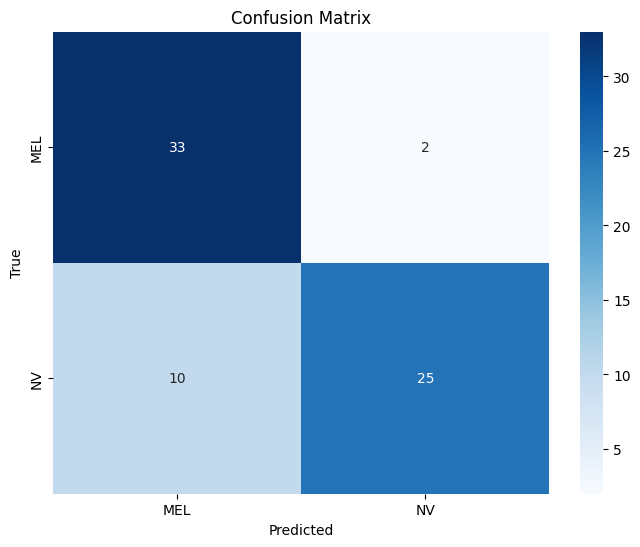

In [77]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
# Konvertiere die Wahrscheinlichkeiten in Klassenindizes
Ytest_pred = np.argmax(Ytest_pred_probabilities, axis=1)
# Drucke einzigartige Werte in Ytest_true und Ytest_pred
print("Unique values in Ytest_true:", np.unique(Ytest))
print("Unique values in Ytest_pred:", np.unique(Ytest_pred))

# Drucke die Formen von Ytest_true und Ytest_pred


# Berechne die Confusion Matrix
Ytest_true=np.argmax(Ytest, axis=1)

print("Shape of Ytest_true:", Ytest_true.shape)
print("Shape of Ytest_pred:", Ytest_pred.shape)

f1 = f1_score(Ytest_true, Ytest_pred, average=None)
print("F1 ",f1,"\n")

conf_matrix = confusion_matrix(Ytest_true, Ytest_pred)
# Plotte die Confusion Matrix als Heatmap
classes = ["MEL", "NV"]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
conf_matrix